In [5]:
prefix = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/"
import_fn = prefix + "data/imports/results.csv"
network_fn = prefix + "results/20231025-zecm/prenetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc"
regions_fn = prefix + "resources/20231025-zecm/regions_onshore_elec_s_110.geojson"
entrypoints_fn = prefix + "resources/20231025-zecm/gas_input_locations_s_110_simplified.csv"
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
config_fn = "../../config/config.yaml"

In [56]:
import sys
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
cc = coco.CountryConverter()

sys.path.append("../pypsa-eur/scripts")

from plot_power_network import assign_location
from pypsa.plot import add_legend_circles, add_legend_patches

plt.style.use(["bmh", matplotlibrc_fn])

In [7]:
with open(config_fn, "r") as f:
    config = yaml.safe_load(f)

tech_colors = config["plotting"]["tech_colors"]
tech_colors["lng"] = "tomato"
tech_colors["pipeline"] = "orchid"

In [8]:
NICE_NAMES = {
    "pipeline-h2": r"H$_2$ (pipeline)",
    "shipping-lh2": "H$_2$ (ship)",
    "shipping-lnh3": "ammonia",
    "shipping-lch4": "methane",
    "shipping-meoh": "methanol",
    "shipping-ftfuel": "Fischer-Tropsch",
    "shipping-steel": "steel",
}

In [10]:
bus_size_factor = 7.5e4

In [11]:
crs = ccrs.EqualEarth()

In [12]:
n = pypsa.Network(network_fn)
assign_location(n)

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [13]:
regions = (
    gpd.read_file(regions_fn).set_index("name").to_crs(crs.proj4_init)
)

In [14]:
inputs = pd.read_csv(entrypoints_fn, index_col=0)[
    ["lng", "pipeline"]
].copy()
countries = ["DE", "GB", "BE", "FR", "EE", "LV", "LT", "FI"]
pattern = "|".join(countries)
inputs.loc[inputs.index.str.contains(pattern), "pipeline"] = 0.0
inputs = inputs.stack()

In [15]:
h2_cost = n.generators.filter(regex="import (pipeline-h2|shipping-lh2)", axis=0)
regions["marginal_cost"] = h2_cost.groupby(
    h2_cost.bus.map(n.buses.location)
).marginal_cost.min()

In [16]:
# patch network
n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
if "KZ" in n.buses.index:
    n.buses.loc["KZ", "x"] = 52
    n.buses.loc["KZ", "y"] = 49
if "CN-West" in n.buses.index:
    n.buses.loc["CN-West", "x"] = 79
    n.buses.loc["CN-West", "y"] = 38
for ct in n.buses.index.intersection({"MA", "DZ", "TN", "LY", "EG", "SA"}):
    n.buses.loc[ct, "y"] += 2

link_colors = pd.Series(
    n.links.index.map(
        lambda x: "olivedrab" if "import hvdc-to-elec" in x else "tan"
    ),
    index=n.links.index,
)


exporters = config["sector"]["import"]["endogenous_hvdc_import"][
    "exporters"
]
techs = [
    "external solar-utility",
    "external onwind",
    "external battery",
    "external H2",
]
mi = pd.MultiIndex.from_product([exporters, techs])
bus_sizes_plain = pd.concat(
    [pd.Series(0.3, index=mi), inputs.div(bus_size_factor)], axis=0
)

In [17]:
bus_sizes_plain

DZ     external solar-utility    0.300000
       external onwind           0.300000
       external battery          0.300000
       external H2               0.300000
EG     external solar-utility    0.300000
                                   ...   
RO1 0  lng                       0.131938
       pipeline                  0.632304
SE2 1  lng                       0.008796
SE2 2  lng                       0.008796
SK1 0  pipeline                  1.254241
Length: 123, dtype: float64

In [18]:
bus_sizes_plain.index.levels[1].difference(pd.Index(tech_colors.keys()))

Index([], dtype='object')

In [19]:
df = pd.read_csv(import_fn, sep=";", keep_default_na=False)

df["exporter"] = df.exporter.replace("", "NA")
ic = df.query("subcategory == 'Cost per MWh delivered' and esc != 'hvdc-to-elec'")
ic["exporter"] = ic.exporter.str.split("-").str[0]

highlighted_countries = ["DZ", "AR", "SA", "CL"]
ic["exporter"] = ic.exporter.apply(lambda x: cc.convert(names=x, to="name_short") if x in highlighted_countries else "Other")

ic["esc"] = ic.esc.map(NICE_NAMES)

/tmp/ipykernel_50060/482237100.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ic["exporter"] = ic.exporter.str.split("-").str[0]
/tmp/ipykernel_50060/482237100.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ic["exporter"] = ic.exporter.apply(lambda x: cc.convert(names=x, to="name_short") if x in highlighted_countries else "Other")
/tmp/ipykernel_50060/482237100.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [127]:
def create_stripplot(ic, ax):

    palette = {
        "Argentina": "#74acdf",
        "Algeria": "#d21034",
        "Namibia": "#003580",
        "Saudi Arabia": "#006c35",
        "Chile": "darkorange",
        "Other": "#aaa"
    }

    order = list(NICE_NAMES.values())[:-1]
    minimums = ic.groupby("esc").value.min().round(1)[order].reset_index(drop=True).to_dict()
    maximums = ic.groupby("esc").value.max().round(1)[order].reset_index(drop=True).to_dict()

    sns.stripplot(data=ic, x='esc', y='value', alpha=0.5, hue='exporter', jitter=.28, palette=palette, ax=ax, order=order, size=3.5)
    sns.violinplot(data=ic, x='esc', y='value', linewidth=0, saturation=0.3, cut=0, color='#ddd', fill=True, ax=ax, order=order, zorder=-1)

    ax.set_ylim(0, 190)
    ax.set_xlabel("")#
    ax.set_ylabel("import cost [€/MWh]")
    ax.grid(False)
    ax.set_yticks(np.arange(0, 200, 20))
    ax.set_yticks(np.arange(10, 200, 20), minor=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=18, ha="right")
    handles, labels = ax.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    for x, y in minimums.items():
        ax.text(x, y - 10, str(y), ha="center", va="bottom", fontsize=9)
    for x, y in maximums.items():
        ax.text(x, y + 5, str(y), ha="center", va="bottom", fontsize=9)
    ax.legend(
        title="",
        ncol=1,
        loc=(0.55, 0.05),
        labelspacing=0.3,
        frameon=False
    )
    for spine in ax.spines.values():
        spine.set_visible(False)

/home/fneum/miniconda3/envs/pypsa-eur-20230725/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/fneum/miniconda3/envs/pypsa-eur-20230725/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/fneum/miniconda3/envs/pypsa-eur-20230725/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


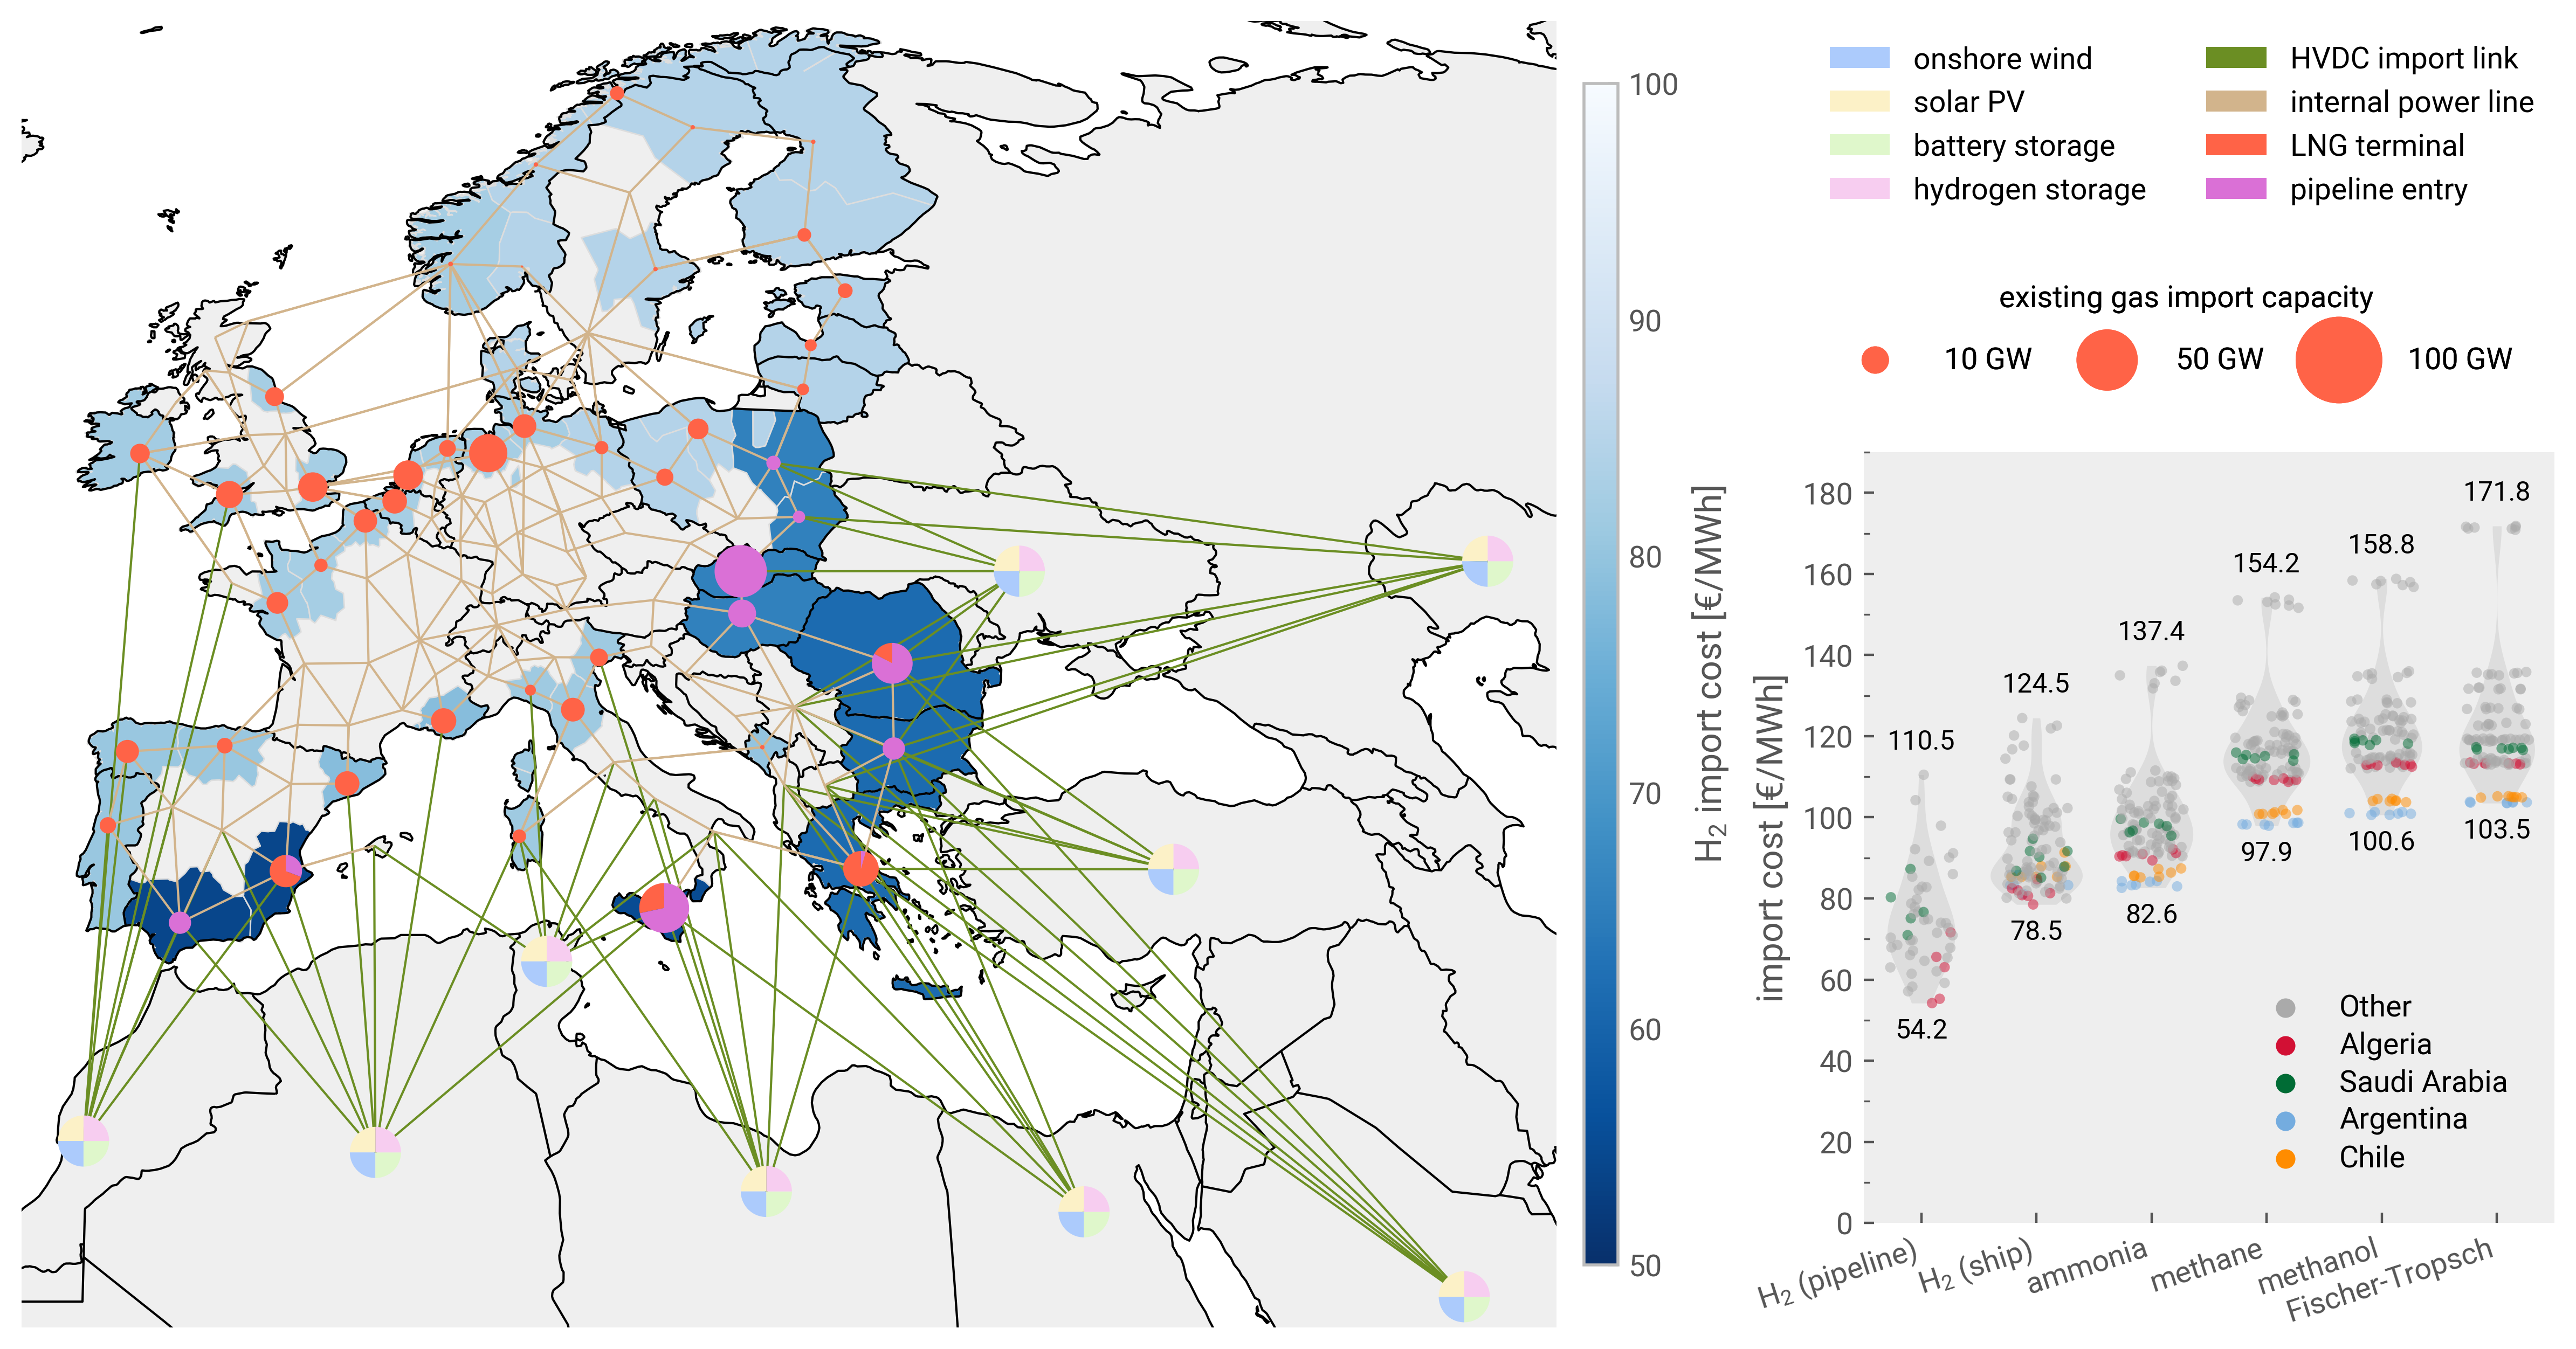

In [136]:

fig, ax = plt.subplots(subplot_kw={"projection": crs})

fig.set_size_inches(14,14)

n.plot(
    ax=ax,
    color_geomap={"ocean": "white", "land": "#efefef"},
    bus_sizes=bus_sizes_plain,
    bus_colors=tech_colors,
    line_colors="tan",
    line_widths=0.75,
    link_widths=0.75,
    link_colors=link_colors,
    boundaries=[-11, 48, 25.25, 71.5],
    margin=0,
)

regions.plot(
    ax=ax,
    column="marginal_cost",
    cmap="Blues_r",
    edgecolor='#ddd',
    linewidths=0.5,
    vmin=50,
    vmax=100,
    legend=True,
    legend_kwds={
        "label": r"H$_2$ import cost [€/MWh]",
        "shrink": 0.4,
        "pad": 0.015,
        "aspect": 35,
    },
)

names = {
    "external onwind": "onshore wind",
    "external solar-utility": "solar PV",
    "external battery": "battery storage",
    "external H2": "hydrogen storage",
}
labels = list(names.values()) + ["HVDC import link", "internal power line", "LNG terminal", "pipeline entry"]
colors = [tech_colors[c] for c in names.keys()] + ["olivedrab", "tan", "tomato", "orchid"]

legend_kw = dict(
    loc=(1.17, 0.85), frameon=False, title="", ncol=2
)

add_legend_patches(
    ax,
    colors,
    labels,
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc=(1.19, 0.72),
    frameon=False,
    title="existing gas import capacity",
    ncol=3,
    labelspacing=1.1,
)

add_legend_circles(
    ax,
    [10e3 / bus_size_factor, 50e3 / bus_size_factor, 100e3 / bus_size_factor],
    ["10 GW", "50 GW", "100 GW"],
    patch_kw=dict(facecolor="tomato"),
    legend_kw=legend_kw,
)

ax.add_feature(
    cfeature.BORDERS.with_scale("50m"),
    linewidth=.75,
    color='k',
)

ax.add_feature(
    cfeature.COASTLINE.with_scale("50m"),
    linewidth=.75,
    color='k',
)

ax_lr = ax.inset_axes([1.2, 0.08, 0.45, 0.59])

create_stripplot(ic, ax_lr)

plt.tight_layout()

plt.savefig("test.pdf", dpi=fig.dpi, bbox_inches='tight')